In [1]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import os
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#datapath='./Dataset/'
datapath = "../input/seoul-bike-rental-ai-pro-iti/"
df = pd.read_csv(os.path.join(datapath,"train.csv"))
df_test = pd.read_csv(os.path.join(datapath,"test.csv"))
df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.dtypes

ID                             int64
Date                          object
y                              int64
Hour                           int64
Temperature(�C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(�C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

## Data Processing

In [4]:
from sklearn.preprocessing import StandardScaler
def FillOFF(row):
    if(row['daycode']==6 or row['daycode']==7 or row['Holiday']==1):
        return 1
    else:
        return 0
def FillRushHour(row):
    if(row['Hour']>=8 and row['Hour']<=20):
        return 1
    else:
        return 0
def process(data):
    
    data=data.drop(['Dew point temperature(�C)'],axis=1)
    data['Date']=pd.to_datetime(data['Date'],format="%d/%m/%Y")
    data['dayofweek']=data["Date"].dt.day_name()
    data['month']=data['Date'].dt.month
    enc={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    data['daycode']=data['dayofweek'].map(enc)
    data = pd.get_dummies(data, columns = ['Seasons'])
    data['Holiday'], Categorical= pd.factorize(data['Holiday'])
    data['Functioning Day'], Categorical= pd.factorize(data['Functioning Day'])
    data['dayofyear']=data["Date"].dt.dayofyear
    data['OFF']=data.apply(lambda row:FillOFF(row),axis=1)
    return data

df=process(df)
df_test=process(df_test)
df.to_csv('Test.csv')

### Split data (Train/test)

In [5]:
X=df.drop(['ID','y','Date','dayofweek','month'],axis =1)
y=df.iloc[:,2]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

### XGBRegressor

In [6]:
def predict_on_validation_set(model):
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred = np.round(y_pred)
    y_pred[y_pred < 0] = 0
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    
    return (y_pred, y_test, rmsle)

In [7]:

import xgboost as xgb

params={'subsample': 0.5 , 'max_depth':6,'objective':'count:poisson','random_state':519,'colsample_bytree':0.57, 'learning_rate':0.09,
         'alpha':1, 'n_estimators':2000}
clf = xgb.XGBRegressor(**params)
xgtrain = xgb.DMatrix(X_train, y_train)
#cvresult = xgb.cv(clf.get_xgb_params(), xgtrain, num_boost_round=5000, nfold=100,early_stopping_rounds=100, seed=123)
#clf.set_params(n_estimators=cvresult.shape[0])
model=clf.fit(X_train,y_train)
y_pred=model.predict(X_test)

y_pred = y_pred * (1-X_test['Functioning Day'])
from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: %f" % (rmsle))
model.feature_importances_

RMSLE: 0.264935


array([0.07090843, 0.04548001, 0.01897328, 0.01290955, 0.00963479,
       0.03158325, 0.03340268, 0.01765486, 0.0125096 , 0.03370406,
       0.01834413, 0.06386355, 0.02131347, 0.05099959, 0.42596886,
       0.03147675, 0.10127318], dtype=float32)

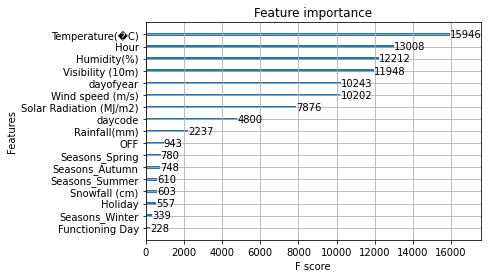

<Figure size 1152x864 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
xgb.plot_importance(clf)
plt.figure(figsize = (16, 12))
plt.show()

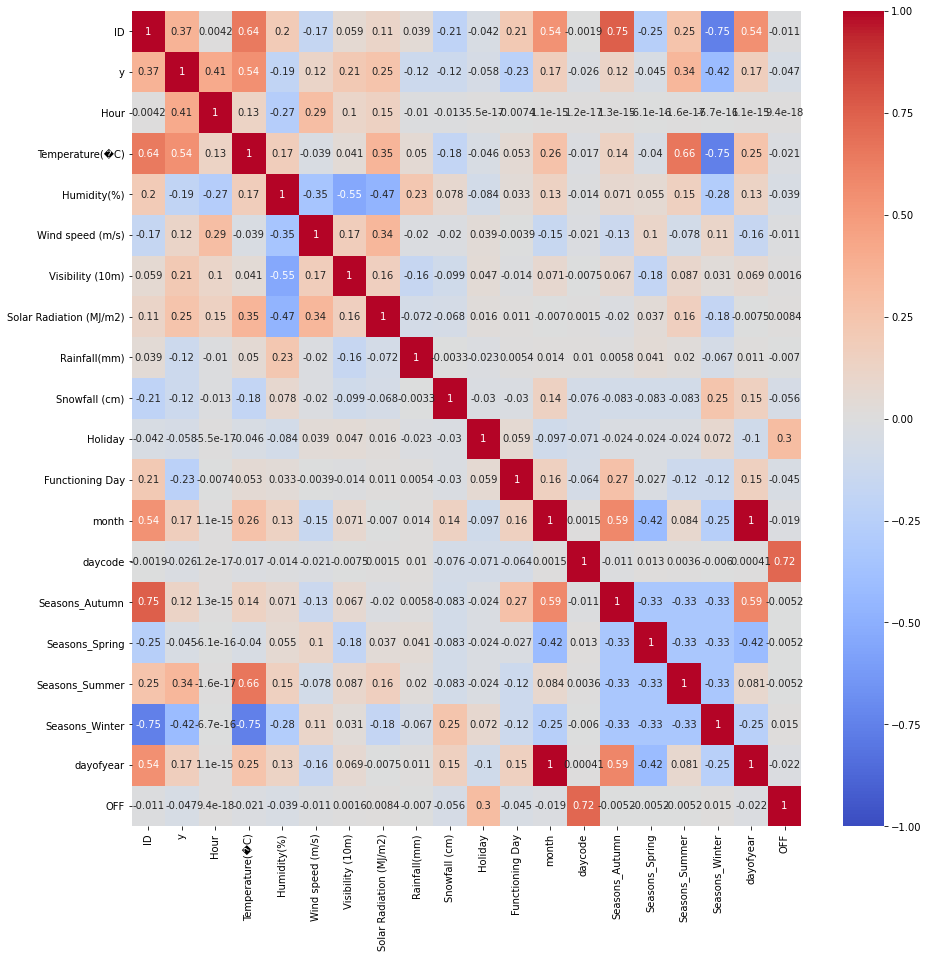

In [9]:
import seaborn as sns
sns.set_palette("RdBu")
plt.figure(figsize=(15,15))
sns.heatmap(df.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            );

In [10]:
X_train.columns

Index(['Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Holiday', 'Functioning Day', 'daycode',
       'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'dayofyear', 'OFF'],
      dtype='object')

In [11]:
X_test = df_test.drop(['ID','Date','dayofweek','month'],axis =1)

y_test_predicted = model.predict(X_test)
y_test_predicted = y_test_predicted*(1-X_test['Functioning Day'])
df_test['y'] = y_test_predicted 


In [12]:
df_test[['ID', 'y']].to_csv('submission.csv', index=False)
result=df_test[['ID', 'y']]
result.head(20)

,ID,y
0,5760,148.113892
1,5761,136.427765
2,5762,88.805138
3,5763,66.338593
4,5764,46.720085
5,5765,45.578476
6,5766,93.306038
7,5767,159.820282
8,5768,237.078522
9,5769,117.780212
